In [1]:
# 📚 Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
import joblib
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 📂 Fichiers et chemins
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
output_dir = "../../models/"
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "model_1_risk_of_default.h5")
scaler_path = os.path.join(output_dir, "scaler_model_1.pkl")

# 📥 Chargement des données
df = pd.read_parquet(input_path)

# ⚙️ Prétraitement et sélection des variables
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
y = df['is_default']

features_to_exclude = [
    'loan_status', 'is_default', 'id',
    'grade', 'sub_grade', 'int_rate', 'installment', 'last_pymnt_d',
    'emp_title', 'emp_title_clean', 'title', 'zip_code',
    'job_category', 'csp_category',
    'issue_d', 'earliest_cr_line'
]
X = df.drop(columns=features_to_exclude, errors='ignore')

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=np.number).columns
X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True, dtype=float)
X_processed = pd.concat([X[numerical_cols], X_categorical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# ⚖️ Gestion du déséquilibre (MODIFICATION)
# On définit manuellement les poids au lieu d'utiliser 'balanced'.
# Cela donne 10 fois plus d'importance à un défaut qu'à un succès.
# N'hésitez pas à tester d'autres valeurs comme 5 ou 15.
class_weights = {
    0: 1,  # Poids pour la classe 'Remboursé'
    1: 10  # Poids pour la classe 'Défaut'
}
print(f"Poids des classes définis manuellement : {class_weights}")

# 🧠 Construction et Entraînement du modèle (LightGBM)
print("\n--- Entraînement avec LightGBM ---")

# Le paramètre scale_pos_weight est l'équivalent de class_weight pour LightGBM
# Il se calcule par : (nombre d'exemples négatifs / nombre d'exemples positifs)
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Ratio pour scale_pos_weight : {ratio:.2f}")

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=ratio  # Gestion de l'équilibre
)

# Entraînement avec arrêt anticipé (early stopping)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=True)]
)

# 📊 Évaluation du modèle LightGBM
print("\n--- Évaluation sur l'ensemble de test (LightGBM) ---")
y_pred_class = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1] # Probabilités pour la classe 1

print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\n--- Rapport de Classification ---")
print(classification_report(y_test, y_pred_class, target_names=['Remboursé (0)', 'Défaut (1)']))
print("\n--- Matrice de Confusion ---")
print(confusion_matrix(y_test, y_pred_class))

# (Optionnel) Sauvegarde du modèle LightGBM
# import joblib
# joblib.dump(lgb_model, os.path.join(output_dir, 'lgbm_model_1.pkl'))

Poids des classes définis manuellement : {0: 1, 1: 10}

--- Entraînement avec LightGBM ---
Ratio pour scale_pos_weight : 4.19
[LightGBM] [Info] Number of positive: 56440, number of negative: 236531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 292971, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192647 -> initscore=-1.432901
[LightGBM] [Info] Start training from score -1.432901
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[638]	valid_0's auc: 0.70674

--- Évaluation sur l'ensemble de test (LightGBM) ---


c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



AUC Score: 0.7067

--- Rapport de Classification ---
               precision    recall  f1-score   support

Remboursé (0)       0.89      0.66      0.76     59133
   Défaut (1)       0.31      0.64      0.42     14110

     accuracy                           0.66     73243
    macro avg       0.60      0.65      0.59     73243
 weighted avg       0.77      0.66      0.69     73243


--- Matrice de Confusion ---
[[38947 20186]
 [ 5048  9062]]


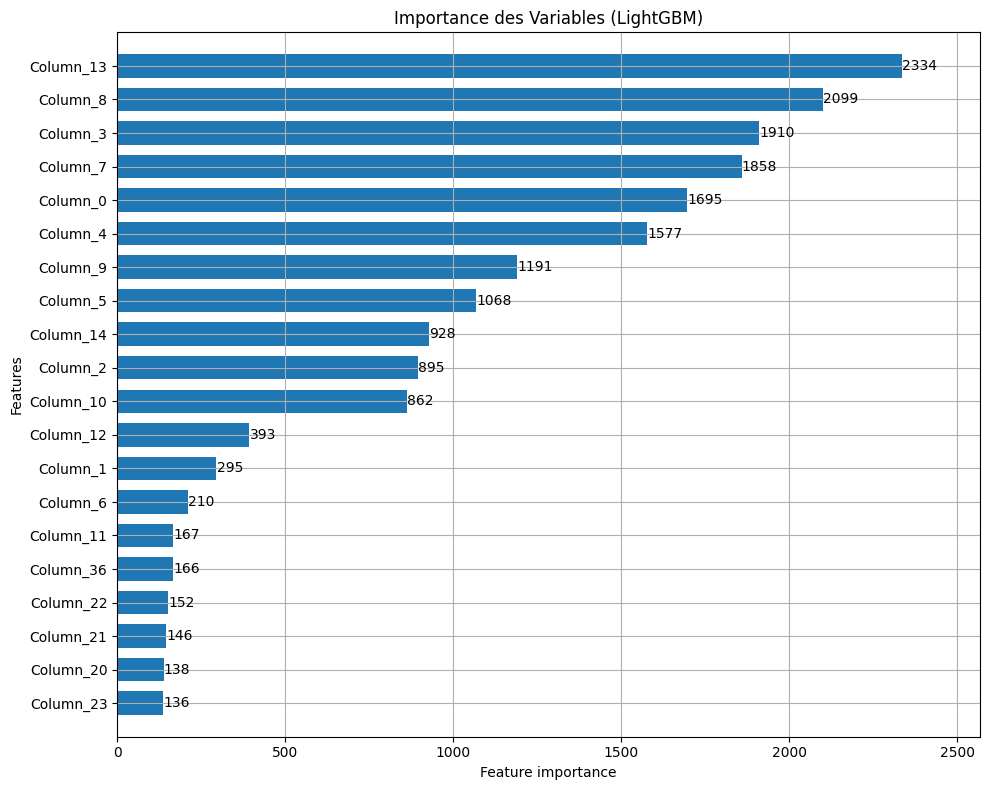

In [10]:
# Visualisation de l'importance des variables
lgb.plot_importance(lgb_model, max_num_features=20, figsize=(10, 8), height=0.7, title="Importance des Variables (LightGBM)")
plt.tight_layout()
plt.show()

--- Démarrage du Modèle v2 : Feature Engineering ---


C:\Users\Pierre\AppData\Local\Temp\ipykernel_8664\2230302392.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['loan_to_income_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Pierre\AppData\Local\Temp\ipykernel_8664\2230302392.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

✅ Nouvelles variables créées : 'credit_history_length', 'loan_to_income_ratio', 'revolving_to_income_ratio'

--- Entraînement du Modèle v2 avec LightGBM ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56440, number of negative: 236531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2839
[LightGBM] [Info] Number of data points in the train set: 292971, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192647 -> initscore=-1.432901
[LightGBM] [Info] Start training from score -1.432901

--- Résultats du Modèle v2 ---
NOUVEL AUC Score: 0.7068

--- Rapport de Classification v2 ---
               precision    

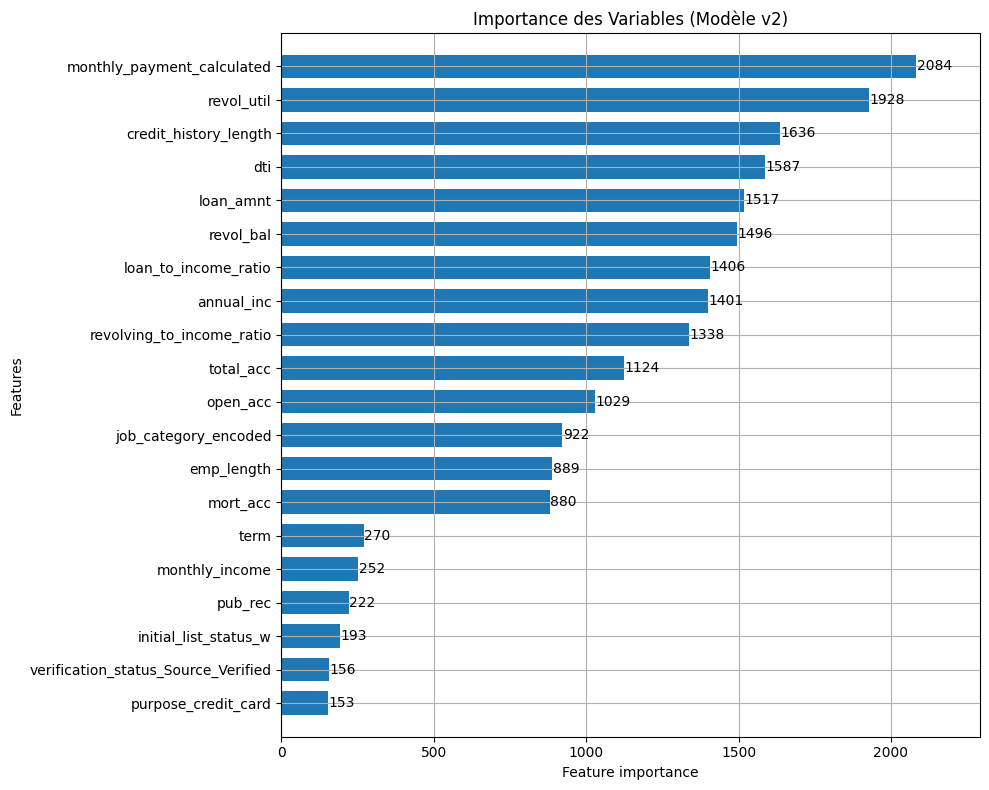

In [3]:
# ==============================================================================
# ✨ Étape 1 : Création de Nouvelles Variables (Feature Engineering)
# ==============================================================================
print("--- Démarrage du Modèle v2 : Feature Engineering ---")

# 📥 Chargement des données
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# Conversion des colonnes de date au format datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

# Création de la variable : Ancienneté de l'historique de crédit en jours
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days

# Création de la variable : Ratio Prêt / Revenu
# On remplace les divisions par zéro ou les infinis par 0
df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']
df['loan_to_income_ratio'].replace([np.inf, -np.inf], 0, inplace=True)

# Création de la variable : Ratio Dette renouvelable / Revenu
df['revolving_to_income_ratio'] = df['revol_bal'] / df['annual_inc']
df['revolving_to_income_ratio'].replace([np.inf, -np.inf], 0, inplace=True)

print("✅ Nouvelles variables créées : 'credit_history_length', 'loan_to_income_ratio', 'revolving_to_income_ratio'")


# ==============================================================================
# ⚙️ Étape 2 : Prétraitement et Sélection
# ==============================================================================

# Définition de la cible (Y)
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
y = df['is_default']

# Sélection des features (X)
features_to_exclude = [
    'loan_status', 'is_default', 'id',
    'grade', 'sub_grade', 'int_rate', 'installment', 'last_pymnt_d',
    'emp_title', 'emp_title_clean', 'title', 'zip_code',
    'job_category', 'csp_category',
    'issue_d', 'earliest_cr_line'
]
X = df.drop(columns=features_to_exclude, errors='ignore')

# Séparation et encodage
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=np.number).columns
X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True, dtype=float)
X_processed = pd.concat([X[numerical_cols], X_categorical], axis=1)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# Note : LightGBM n'a pas besoin de mise à l'échelle, on omet cette étape pour simplifier.


# ==============================================================================
# 🚀 Étape 3 : Entraînement et Évaluation du Modèle v2
# ==============================================================================

print("\n--- Entraînement du Modèle v2 avec LightGBM ---")

# Calcul du poids pour la gestion de l'équilibre
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

lgbm_v2 = lgb.LGBMClassifier(
    objective='binary', metric='auc', n_estimators=1000,
    learning_rate=0.05, random_state=42, n_jobs=-1,
    colsample_bytree=0.8, subsample=0.8, scale_pos_weight=ratio
)

# Entraînement
lgbm_v2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False)] # 'verbose=False' pour un output plus propre
)

# Évaluation
y_pred_proba_v2 = lgbm_v2.predict_proba(X_test)[:, 1]
y_pred_class_v2 = lgbm_v2.predict(X_test)
auc_v2 = roc_auc_score(y_test, y_pred_proba_v2)

print(f"\n--- Résultats du Modèle v2 ---")
print(f"NOUVEL AUC Score: {auc_v2:.4f}")
print("\n--- Rapport de Classification v2 ---")
print(classification_report(y_test, y_pred_class_v2, target_names=['Remboursé (0)', 'Défaut (1)']))
print("\n--- Matrice de Confusion v2 ---")
print(confusion_matrix(y_test, y_pred_class_v2))


# ==============================================================================
# 📊 Étape 4 : Analyse de la v2
# ==============================================================================

# Visualisation de l'importance des variables pour le nouveau modèle
lgb.plot_importance(lgbm_v2, max_num_features=20, figsize=(10, 8), height=0.7, title="Importance des Variables (Modèle v2)")
plt.tight_layout()
plt.show()

In [15]:
# ==============================================================================
# ✨ Étape 5 : Optimisation des Hyperparamètres avec Optuna
# ==============================================================================
print("\n--- Démarrage de l'Optimisation des Hyperparamètres ---")

# La fonction 'objective' est ce qu'Optuna va essayer d'optimiser.
# À chaque 'trial' (essai), il teste une nouvelle combinaison de paramètres.
def objective(trial):
    # Définition de la plage de recherche pour chaque hyperparamètre
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'seed': 42,
        'n_jobs': -1,
        'verbose': -1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': ratio # On garde le ratio calculé précédemment
    }
    
    # Entraînement avec les paramètres du 'trial' en cours
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    # Calcul du score AUC sur les données de test
    preds = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    
    return auc

# Création d'une "étude" Optuna pour maximiser l'AUC
study = optuna.create_study(direction='maximize')
# Lancement de 50 essais (vous pouvez augmenter ce nombre pour une recherche plus poussée)
study.optimize(objective, n_trials=50)

# Affichage des meilleurs résultats
print("\n--- Optimisation Terminée ---")
print(f"Nombre d'essais terminés : {len(study.trials)}")
print("Meilleurs paramètres trouvés :")
print(study.best_params)
print(f"Meilleur score AUC : {study.best_value:.4f}")

[I 2025-07-03 14:59:46,332] A new study created in memory with name: no-name-35172694-6d49-48c6-b7e5-f0ad07041863



--- Démarrage de l'Optimisation des Hyperparamètres ---


[I 2025-07-03 15:00:02,001] Trial 0 finished with value: 0.7055709322890825 and parameters: {'learning_rate': 0.01629666352450526, 'num_leaves': 213, 'max_depth': 10, 'colsample_bytree': 0.9777429843952861, 'subsample': 0.8137262458245613, 'reg_alpha': 0.6840803732295764, 'reg_lambda': 0.3557964942368488}. Best is trial 0 with value: 0.7055709322890825.
[I 2025-07-03 15:00:07,168] Trial 1 finished with value: 0.7054174673788187 and parameters: {'learning_rate': 0.09840864625659265, 'num_leaves': 99, 'max_depth': 7, 'colsample_bytree': 0.5965390993504158, 'subsample': 0.5331295617165347, 'reg_alpha': 0.1484110354870869, 'reg_lambda': 0.09184831025006324}. Best is trial 0 with value: 0.7055709322890825.
[I 2025-07-03 15:00:11,932] Trial 2 finished with value: 0.7049201152735459 and parameters: {'learning_rate': 0.09161548962491224, 'num_leaves': 165, 'max_depth': 10, 'colsample_bytree': 0.7700078125506109, 'subsample': 0.5351379270331331, 'reg_alpha': 0.7885198110452811, 'reg_lambda': 0.


--- Optimisation Terminée ---
Nombre d'essais terminés : 50
Meilleurs paramètres trouvés :
{'learning_rate': 0.085040314520708, 'num_leaves': 164, 'max_depth': 4, 'colsample_bytree': 0.5502487938944248, 'subsample': 0.9003353208935612, 'reg_alpha': 0.05207990536259383, 'reg_lambda': 0.5556216228399427}
Meilleur score AUC : 0.7093


In [4]:
# ==============================================================================
# 🏆 Étape Finale : Entraînement du Modèle Champion avec les Meilleurs Paramètres
# ==============================================================================
print("\n--- Entraînement du Modèle Final (Champion) ---")

# On copie les meilleurs paramètres trouvés par Optuna
best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000, # L'early stopping ajustera ce nombre
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'scale_pos_weight': ratio, # On garde le ratio pour l'équilibre
    # Ajout des paramètres optimisés par Optuna
    'learning_rate': 0.085040314520708,
    'num_leaves': 164,
    'max_depth': 4,
    'colsample_bytree': 0.5502487938944248,
    'subsample': 0.9003353208935612,
    'reg_alpha': 0.05207990536259383,
    'reg_lambda': 0.5556216228399427
}

# Initialisation du modèle final avec ces paramètres
final_model = lgb.LGBMClassifier(**best_params)

# Entraînement sur TOUTES les données d'entraînement, avec les données de test pour l'early stopping
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

# Évaluation finale sur l'ensemble de test
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]
y_pred_class_final = final_model.predict(X_test)
final_auc = roc_auc_score(y_test, y_pred_proba_final)

print(f"\n--- Performance du Modèle Champion Final ---")
print(f"AUC FINAL: {final_auc:.4f}")
print("\n--- Rapport de Classification Final ---")
print(classification_report(y_test, y_pred_class_final, target_names=['Remboursé (0)', 'Défaut (1)']))
print("\n--- Matrice de Confusion Finale ---")
print(confusion_matrix(y_test, y_pred_class_final))

# Sauvegarde du modèle final
final_model_path = os.path.join(output_dir, "model_risk_of_default.pkl")
joblib.dump(final_model, final_model_path)
print(f"\n✅ Modèle champion sauvegardé dans : {final_model_path}")


--- Entraînement du Modèle Final (Champion) ---

--- Performance du Modèle Champion Final ---
AUC FINAL: 0.7093

--- Rapport de Classification Final ---
               precision    recall  f1-score   support

Remboursé (0)       0.89      0.67      0.76     59133
   Défaut (1)       0.31      0.64      0.42     14110

     accuracy                           0.66     73243
    macro avg       0.60      0.65      0.59     73243
 weighted avg       0.78      0.66      0.70     73243


--- Matrice de Confusion Finale ---
[[39488 19645]
 [ 5093  9017]]

✅ Modèle champion sauvegardé dans : ../../models/model_risk_of_default.pkl


In [5]:
# X_train est votre jeu de données d'entraînement final pour le Modèle 1
training_columns = X_train.columns.tolist()

# Sauvegarde de cette liste de colonnes
output_dir = "../../models/"
joblib.dump(training_columns, os.path.join(output_dir, "model_1_columns.pkl"))

print(f"✅ Structure de {len(training_columns)} colonnes sauvegardée.")

✅ Structure de 42 colonnes sauvegardée.
